In [1]:
# ! pip install imblearn

In [2]:
# Import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Import ML libs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, f1_score, plot_precision_recall_curve, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#import bootstrap libs
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline

#dummy classifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

In [3]:
# Load data
train_merged = pd.read_csv('../data/train_merged.csv')
test_merged = pd.read_csv('../data/test_merged.csv')
pd.set_option('display.max_columns',99)

In [4]:
train_merged.head(1)

,date,block,latitude,longitude,nummosquitos,wnvpresent,street_ W ARMITAGE AVENUE,street_ E 105TH ST,street_ E 111TH ST,street_ E 115TH ST,street_ E 118TH ST,street_ E 130TH ST,street_ E 138TH ST,street_ E 67TH ST,street_ E 91ST PL,street_ E 91ST ST,street_ E RANDOLPH ST,street_ N ASHLAND AVE,street_ N ASHLAND AVE OVERPASS,street_ N AUSTIN AVE,street_ N AVONDALE AVE,street_ N CALIFORNIA AVE,street_ N CAMPBELL AVE,street_ N CANNON DR,street_ N CENTRAL PARK DR,street_ N FRANCISCO AVE,street_ N HARLEM AVE,street_ N HUMBOLDT DR,street_ N KEDVALE AVE,street_ N LARAMIE AVE,street_ N LAWLER AVE,street_ N LEMONT AVE,street_ N LONG AVE,street_ N MANDELL AVE,street_ N MCCLELLAN AVE,street_ N MILWAUKEE AVE,street_ N MONT CLARE AVE,street_ N MOSELL AVE,street_ N OAK PARK AVE,street_ N OAKLEY AVE,street_ N OKETO AVE,street_ N PITTSBURGH AVE,street_ N PULASKI RD,street_ N RICHMOND ST,street_ N RIDGE AVE,street_ N RUTHERFORD AVE,street_ N SPRINGFIELD AVE,street_ N STAVE ST,street_ N STREETER DR,...,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,daylightmins,tminsq,tmaxsq,tavgsq,departsq,wetbulbsq,heatsq,coolsq,preciptotalsq,resultspeedsq,resultdirsq,avgspeedsq,stnpressuresq,sealevelsq,daylightminssq,tmin_sma_3,tmax_sma_3,tavg_sma_3,tmin_sma_7,tmax_sma_7,tavg_sma_7,daylightmin_sma_3,daylightmin_sma_7,avgspeed_sma_3,avgspeed_sma_7,resultspeed_sma_3,resultspeed_sma_7,stnpressure_sma_3,stnpressure_sma_7,heat_sma_3,heat_sma_7,cool_sma_3,cool_sma_7,wetbulb_sma_3,wetbulb_sma_7,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_OTHERS
0,2007-05-29,41,41.95469,-87.800991,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,896.0,3600.0,7744.0,5476.0,100.0,4225.0,0.0,81.0,0.0,33.64,324.0,42.25,863.7721,906.6121,802816.0,54.666667,81.0,68.0,54.142857,75.428571,64.857143,895.333333,894.285714,5.666667,7.242857,5.1,5.385714,29.436667,29.405714,0.0,1.857143,3.0,1.714286,59.333333,57.714286,0,1,0,0


## Baseline Model

In [5]:
#define X, y
X = train_merged.drop(columns = ['block','wnvpresent','date','nummosquitos','stnpressure','stnpressuresq','sealevel','sealevelsq','stnpressure_sma_3','stnpressure_sma_7'])
y = train_merged['wnvpresent']

In [6]:
baseline = y.value_counts(normalize=True)

In [7]:
print(f'Imbalanced Data Baseline Accuracy: {baseline[0].round(3)}%')

Imbalanced Data Baseline Accuracy: 0.947%


In [8]:
print(f"Balanced Data Baseline Accuracy: 0.5%")

Balanced Data Baseline Accuracy: 0.5%


## Train Test Split

In [9]:
#split train test 
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

## Pipeline

Pipeline with oversampling bootstrapping (SMOTE). Metric is using ROC-AUC as we are trying to identify the accuracy of the model.

In this scenario, the identification of the true cases (WNV Present) to the False Negative (Type II error where predicted to be not present proved to be otherwise) in order to better navigate resources to the location for pesticide control.

### Logistic Regression

In [10]:
#Instantiate pipeline 
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(random_state=42, max_iter=10000))
])

#set pipe params
pipe_params = {
    'logreg__solver' : ['liblinear','lbfgs'],
    'logreg__C': np.logspace(-2, 1, 1),
    'logreg__class_weight':["balanced",]
}

#gridsearch
gs = GridSearchCV(pipe, pipe_params,  cv=5,n_jobs=-1, scoring='roc_auc')
#fit model
gs.fit(X_train, y_train)
best_logreg = gs.best_estimator_

print('Training Accuracy: ', best_logreg.score(X_train, y_train))
print('Testing Accuracy: ', best_logreg.score(X_test, y_test))
print('\n')
gs.best_params_

Training Accuracy:  0.7661672429248303
Testing Accuracy:  0.7427035330261137




{'logreg__C': 0.01,
 'logreg__class_weight': 'balanced',
 'logreg__solver': 'liblinear'}

### K Nearest Neighbours

In [11]:
#Instantiate pipeline
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

#set pipe params
pipe_params = {
    'knn__n_neighbors' : [3,5,7,10],
    'knn__weights' : ['uniform','distance'],
    'knn__p': [1,2]
}
#grid search
gs = GridSearchCV(pipe, pipe_params, cv=5 ,n_jobs=-1, scoring='roc_auc')
#fit model
gs.fit(X_train, y_train)
best_knn = gs.best_estimator_

print('Training Accuracy: ', best_knn.score(X_train, y_train))
print('Testing Accuracy: ', best_knn.score(X_test, y_test))
print('\n')
gs.best_params_

Training Accuracy:  0.8693814829043411
Testing Accuracy:  0.8079877112135176




{'knn__n_neighbors': 10, 'knn__p': 1, 'knn__weights': 'uniform'}

### Random Forest

In [12]:
#Instantiate pipeline
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, bootstrap=True))
])

#set pipe params
pipe_params = {
    'rf__n_estimators': [100,150,250],
    'rf__max_depth': [1,3,9,10]
}
#grid search
gs = GridSearchCV(pipe, pipe_params, cv=5 ,n_jobs=-1, scoring='roc_auc')
#fit model
gs.fit(X_train, y_train)
best_rf = gs.best_estimator_

print('Training Accuracy: ', best_rf.score(X_train, y_train))
print('Testing Accuracy: ', best_rf.score(X_test, y_test))
print('\n')
gs.best_params_

Training Accuracy:  0.8843641951594314
Testing Accuracy:  0.8778801843317973




{'rf__max_depth': 10, 'rf__n_estimators': 250}

In [13]:
#display result in dataframe
model_df = pd.DataFrame({
    'Model' :['Balanced Baseline','Logistic Regression','K Nearest Neighbors','Random Forest'],
    'Training Accuracy' : [0.5, best_logreg.score(X_train, y_train),best_knn.score(X_train, y_train),best_rf.score(X_train, y_train)],
    'Test Accuracy' : [0.5 ,best_logreg.score(X_test, y_test),best_knn.score(X_test, y_test),best_rf.score(X_test, y_test)]
})

model_df

,Model,Training Accuracy,Test Accuracy
0,Balanced Baseline,0.500000,0.500000
1,Logistic Regression,0.766167,0.742704
2,K Nearest Neighbors,0.869381,0.807988
3,Random Forest,0.884364,0.877880


## Model Selection

Based on the training and test set ROC AUC score, the best model with the best score is using Random Forest Classifier for both training and test set. 

In [14]:
#model selection and prediction for validation 
best_model = best_rf
best_model.fit(X_train,y_train)

#predict all datasets
y_preds = best_model.predict(X)

In [15]:
#compare ytest and prediction
pred_df = pd.DataFrame({'true_values': y,
                        'preds_values': y_preds})

pred_df.head()

,true_values,preds_values
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


## Model Evaluation

### Confusion Matrix

In [16]:
#plot cm to check for prediction accuracy
cm = confusion_matrix(y,y_preds)

In [17]:
tn,fp,fn,tp = confusion_matrix(y, y_preds).ravel()

In [18]:
print(f'True Negatives: {tn}') #predict absent is absent
print(f'False Positives: {fp}') #predict present but absent
print(f'False Negatives: {fn}') #predict absent but present
print(f'True Positives: {tp}') #predict present is present

True Negatives: 8897
False Positives: 965
False Negatives: 256
True Positives: 295


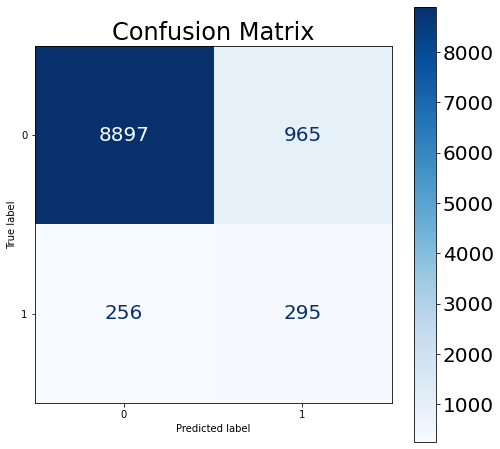

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.rcParams.update({'font.size': 20})
plot_confusion_matrix(best_model, X, y, cmap= 'Blues', 
                  values_format='d', ax=ax );
plt.title('Confusion Matrix')
plt.savefig('../images/confusion_matrix.png')
plt.show()

*Confusion matrix plotted for Predicted and True Values for Class 1 (WNV Present) to Class 0 (No WNV Present) demonstrates the specificity and sensitivity of the model.*

In [20]:
#calculate sensitivity specificty and precision
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp/(fp+tp)

In [21]:
print("Sensitivity: ", round(sensitivity,2))
print("Specificity: ", round(specificity,2))
print("Precision:", round(precision,2))

Sensitivity:  0.54
Specificity:  0.9
Precision: 0.23


In this problem statement, the concern on the model prediction will be the false negative, also known as Type II error. With specificity/ recall at 0.88, and sensitivity at 0.59 the model is able to identify the true positive rate and true negative rate accordingly.

However, the precision score is low at 0.22 only. This means the model has been predicting cases as positive more than it should have been. 

### ROC AUC

In [22]:
#calculate TPR and TNR
TPR = sensitivity
print("True Positive Rate: ", round(TPR,2))
TNR = 1 - specificity
print("True Negative Rate (False Positive Rate)", round(TNR,2))

True Positive Rate:  0.54
True Negative Rate (False Positive Rate) 0.1


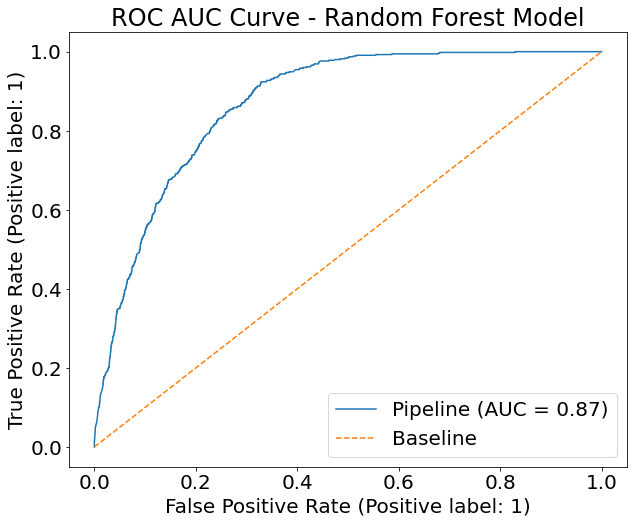

In [23]:
#plot ROC AUC curve for RF model
fig, ax = plt.subplots(figsize=(10, 8))
plot_roc_curve(best_model,X,y,ax=ax)
plt.plot([0,1],[0,1], color='tab:orange', linestyle='--', label='Baseline')

plt.title('ROC AUC Curve - Random Forest Model')
plt.legend()
plt.savefig('../images/ROC_AUC.png')
plt.show()

### Model Threshold Adjustment

The model has a huge gap for improvement, in which the existing pipeline only has AUC of 0.87. Hence, we will look into the model prediction to observe the possible threshold changes.

In [24]:
#y_test vs predict proba
pred_prob_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': best_model.predict_proba(X_test)[:,1]})

pred_prob_df.head()

,true_values,pred_probs
4459,0,0.022893
4099,0,0.004296
4423,0,0.016854
521,0,0.042157
10393,0,0.303384


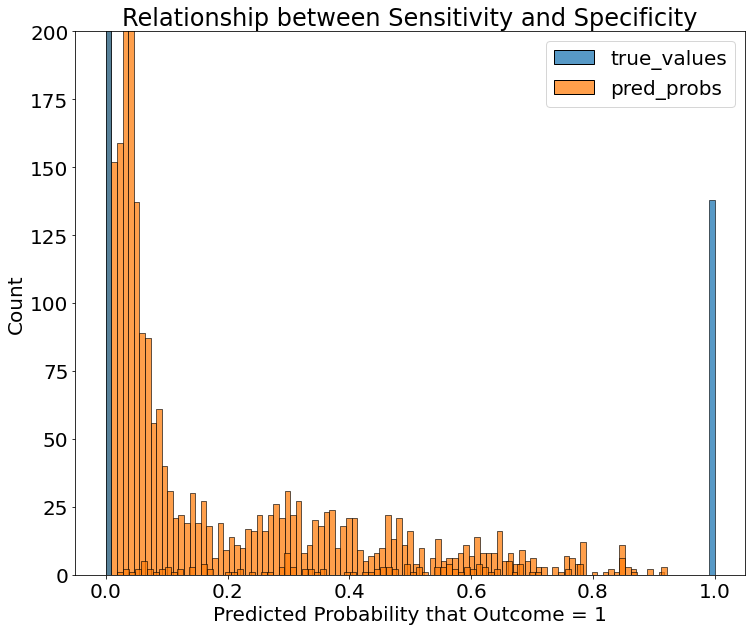

In [25]:
plt.figure(figsize = (12, 10))

# plot distributions of predicted probabilities by actual values
for group in pred_prob_df.groupby('true_values'):
    sns.histplot(group[1], kde = False, bins = 100)

plt.xlabel('Predicted Probability that Outcome = 1')
plt.title('Relationship between Sensitivity and Specificity')
plt.ylim(0,200)
plt.show()

**Observation:** The overlap between the predictions are high and mostly inclined for 0 prediction. 

In [26]:
#define function to get predictions from probabilities and threshold
def get_predictions(probabilities, threshold):
    return [0 if prob < threshold else 1 for prob in probabilities]

In [27]:
threshold_list = [0.45, 0.5, 0.55, 0.6]
#calculate predictions from probabilities and threshold
for threshold in threshold_list:
    preds = get_predictions(best_model.predict_proba(X_test)[:,1], threshold)
    rec = recall_score(y_test, preds)
    prec = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print(f'Threshold: {threshold:.2f}, Recall: {rec:.2f}, Precision: {prec:.2f}, f1 : {f1:.2f}')

Threshold: 0.45, Recall: 0.53, Precision: 0.18, f1 : 0.27
Threshold: 0.50, Recall: 0.44, Precision: 0.20, f1 : 0.28
Threshold: 0.55, Recall: 0.38, Precision: 0.21, f1 : 0.27
Threshold: 0.60, Recall: 0.29, Precision: 0.20, f1 : 0.24


The threshold changes does not improve beyond the current model, of 0.22, however take a huge dive in the recall. In this matter, no changes on the threshold will be made on the existing model. 

### Feature Importance

In [28]:
best_rf

Pipeline(steps=[('ss', StandardScaler()),
                ('oversample', SMOTE(random_state=42)),
                ('rf',
                 RandomForestClassifier(max_depth=10, n_estimators=250,
                                        random_state=42))])

In [29]:
# Extracting feature importances
rf = RandomForestClassifier(max_depth=15, n_estimators=150)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=150)

In [30]:
rf.feature_importances_

array([5.20979538e-02, 5.84259174e-02, 2.64450516e-03, 1.71920868e-03,
       4.69032253e-04, 7.97363446e-04, 1.08205003e-03, 4.04952645e-03,
       5.55235796e-04, 2.70168112e-03, 1.62738740e-03, 1.59478761e-03,
       5.36190245e-07, 1.25460830e-03, 6.23086942e-04, 6.09471432e-04,
       4.55205766e-05, 5.45212595e-06, 1.50807109e-03, 2.37898691e-03,
       3.37648393e-03, 2.38110087e-03, 2.70130681e-03, 1.90719232e-03,
       8.85856624e-04, 3.55152463e-03, 9.85564738e-04, 1.19956459e-03,
       7.29844777e-06, 4.48267266e-05, 9.90289910e-04, 6.66888187e-03,
       4.06933949e-03, 5.59546695e-03, 9.48085521e-03, 3.54004770e-05,
       4.08160777e-03, 4.91803435e-03, 5.96827615e-03, 2.32434382e-05,
       1.48354982e-04, 1.03878820e-03, 2.79626195e-03, 2.03194087e-05,
       5.16841304e-06, 6.75449085e-06, 3.14990817e-03, 1.61830883e-03,
       2.25903538e-03, 3.23084607e-05, 1.24450075e-03, 5.41181257e-04,
       1.02198129e-03, 6.35007037e-06, 2.09913458e-03, 2.00639933e-03,
      

In [31]:
#create df for feature importance
df_fi = pd.DataFrame(zip(X.columns, rf.feature_importances_))
df_fi = df_fi.rename(columns={df_fi.columns[0]: 'feature',df_fi.columns[1]: 'importance'})
df_fi = df_fi.round(5)

In [32]:
#sort features by most important
df_fi.sort_values(by = 'importance', ascending = False).head(30)

,feature,importance
310,species_CULEX PIPIENS/RESTUANS,0.05949
1,longitude,0.05843
0,latitude,0.05210
309,species_CULEX PIPIENS,0.04840
311,species_CULEX RESTUANS,0.02871
297,daylightmin_sma_3,0.02062
298,daylightmin_sma_7,0.01932
278,daylightmins,0.01800
290,daylightminssq,0.01540
307,wetbulb_sma_3,0.01208


The direct longitude and lattitude and the species are the critical features affecting the presence of WNV. We also observe the daylightmins also affecs the exposure for the mosquitos as well.

Other features like the street, we see top two street, Ohare Airport and Oak Park Avenue at the North area of Chicago streets that has higher odds in the exposure of WNV mosquitos.

This proves otherwise for the South area (Hamlin Ave, Wallace St, Racine Ave, 85th St, 77th St, Randolph St, Pershing Road, SunnySide Ave, Longwood Road, and Streeter Drive, making these locations WNV-free.

In [33]:
#prepare test set for fit on model
X_test = test_merged[X.columns]

In [34]:
#predict wnvpresent for test set using rf model
kaggle_score = pd.DataFrame(zip(test_merged.id, gs.predict(X_test)))

In [35]:
#rename columns for kaggle score
kaggle_score.rename(columns = {0:"Id", 1: "WnvPresent"}, inplace = True)

In [36]:
#save kagglescore to csv for submission
kaggle_score.to_csv('../data/best_submission.csv', index= False)

## Conclusion

Our final model had an AUCROC score of 0.88 on the test set, a 38% improvement from the data.  Locational features were picked out by the model as the most important, followed by the species of mosquito, dominating other weather features that might have predicted mosquito propagation such as temperature and precipitation.

However, when predicting WNV in 2008, 2010, 2012 and 2014, there was a significant difference in our accuracy on the test set between our submission score of 0.67 and the leading Kaggle scores of 0.85.  This suggests that our model did not generalise well.  Apart from collating more data, the low score might be due to the following factors:

1. Locations of WNV outbreak might have been different in the prediction years.
2. Highly imbalanced data set and possibility of spike during even years.
3. Use spray data in the model, joined on date of spray, to see if it would have further impact.


## Recommendations

To reduce the spread of WNV, it might be interesting to take a leaf out of other tropical countries such as Singapore, a small city-state with a population of about 5.7 million.  The hot and  humid temperatures means in Singapore mean it is mosquito season all year round.  However, Singapore's National environment Agency  has reduced the number of [dengue cases](https://www.straitstimes.com/singapore/singapores-weekly-dengue-cases-at-lowest-level-this-year-following-historic-outbreak#:~:text=SINGAPORE%20%2D%20Dengue%20cases%20have%20fallen,of%201%2C792%20cases%20in%20July.) through a mixture of education, fogging and bio-engineering.



__1. Spray the right areas__
As location was the most important factor, it is likely that spray coverage during the mosquito season is one of the key driving factors to curb the spread of WNV.  As could be seen from the EDA, the CDC of Chicagoonly started spraying in 2011, and not all the locations where the virus was present was covered.  

More significantly, locations which the model picked out, such as Chicago O'Hare Airport and North Oak Parks Avenue (central/east) of Chicago did not seem to be within the coverage of the spray.  These areas should be prioritised.

__1.1 Cost benefit analysis of spraying__

The cost of spraying the entire Chicago metropolitan area can be roughly estimated by the following formula:

> * `US$700` ([Cost per acre per season](https://www.homeadvisor.com/cost/environmental-safety/mosquito-control/)) * `149,894` ([land area of Chicago metropolitan area]) = US$ 104,925,800

The benefits from preventing WNV can be roughly estimated in two parts using the following formula:

> * Value of human lives saved = `1` ([Average number of deaths per year from 2007 to 2014](http://www.idph.state.il.us/envhealth/wnvnews.htm)) * `9,100,00` ([value of human life](https://www.nytimes.com/2011/02/17/business/economy/17regulation.html?_r=0&pagewanted=all)) = `US$9,100,000`
> * Value of lives improved (by not contracting the virus) = `56.25` ([Average number of people who contract WNV per year from 2007 to 2014](http://www.idph.state.il.us/envhealth/wnvnews.htm)) * `US$272,973` ([Value of human lives improved including cost of treatment, loss of income etc](https://www.npr.org/sections/health-shots/2014/02/11/275262857/the-high-cost-of-treating-people-hospitalized-with-west-nile-virus#:~:text=The%20team%20then%20used%20an,%24678%20million%20to%20%241.01%20billion.)) = `US$15,354,731.25`   
> * Total benefits = `US$9.1M` + `US$15.4M` = `US$24.5M`

From this data, it can be seen that the cost of spraying the entire Chicago metropolitan area exceed the benefits.  This means that spraying should only be used as a measure of last resort on specific clusters, or when the number of mosquitos caught in the trap are high.


__2. Active outreach and monitoring__

According to the [WHO](https://www.who.int/news-room/fact-sheets/detail/west-nile-virus#:~:text=West%20Nile%20virus%20can%20cause,disease%20and%20death%20in%20horses.), the most effective method to reduce the transmission rate of the WNV is through source control.  This may include weekly inspection and cleaning of possible breeding sites for mosquitos such as drains, ponds or other places with stagnant water and refuse.

For example, the scope of work for mosquito control as espoused by the National Environmental Agency(NEA) in Singapore [include the following](https://www.nea.gov.sg/our-services/pest-control/mosquito-control/mosquito-control-in-condominium-estates):

> * Weekly measures to check for mosquito breeding sites in drains, puddles, tree holes, outdoor bins, rooftops and any other containers.
> * Fortnightly measures checking roof drainage and gutters in all structures and application of sand granular insecticide in gully traps, manholes and valve chambers

In addition, public health educational messages should focus on the protection of individuals or communities against mosquito bites such as through the use of mosquito nets, insect repellants and by avoiding outdoor activity at peak breeding times.


__3. Bioengineering__

Should WNV concerns remain or if fogging/use of insecticides might not be welcome by the Chicago public, it may be interesting to explore genetic modification or biological engineering to further limit the population of the 2 WNV carrying mosquito species, _C. Pipiens_ and _C. Restauns_.

> * Reduce vectors of transmissions and reservoir hosts such as birds, which pass on the WNV virus to mosquitos after feeding.
> * Implement Sterile Insect Techniques (SIT) where large numbers of sterile wild male mosquitoes are released in the wild.  However, over time the numbers of the targeted mosquito species will return to normal.
> * Male mosquitoes do not bite peopole or animals and mainly feed on nectar.  Therefore, people living in the release area will not be bitten more than normal.
